#### methods

In [2]:
import pandas as pd
import pyarrow.csv as pcv
import numpy as np

import rockfish as rf
import rockfish.actions as ra
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import pickle
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
conn = rf.Connection.local()

In [5]:
def search_model(label: dict, conn: rf.Connection) -> rf.Model:
    return conn.list_models(labels=label).last()

In [6]:
async def generate_data(model: rf.Model, amplify: ra.PostAmplify, conn: rf.Connection) -> pd.DataFrame:
    session_target = ra.SessionTarget(target=1500, max_cycles=250)

    builder = rf.WorkflowBuilder()
    builder.add_model(model)
    builder.add_action(ra.GenerateTimeGAN(), alias='gen', parents=[model, session_target])
    builder.add_action(amplify, parents=['gen'])
    builder.add_action(session_target, parents=[amplify])
    builder.add_action(ra.DatasetSave(name='demo_central_syn'), parents=[amplify])
    workflow = await builder.start(conn)
    print(workflow.id())
    async for log in workflow.logs():
        print(log)
    data = await (await workflow.datasets().concat(conn)).to_local(conn)
    return data.to_pandas()

In [7]:
def get_xgb_clf(X_train, y_train, X_valid, y_valid):
    clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, enable_categorical=True)
    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    return clf

In [8]:
def create_X_y_for_xgb(datasets):
    session_key = "customer"
    X_columns = ["customer", "age", "gender", "merchant", "category", "amount"]
    cat_columns = ["customer", "age", "gender", "merchant", "category"]
    y_columns = ["fraud"]
    df = pd.concat(datasets)

    X = df[X_columns]
    X[cat_columns] = X[cat_columns].astype("category")
    y = df[y_columns]

    return X, y

In [9]:
def metrics(y, y_pred):
    dat = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_pred),
        #'classification_report': classification_report(y, y_pred),
        #'confusion_matrix': confusion_matrix(y, y_pred)
    }
    return pd.DataFrame(dat, index=[0])

In [10]:
def get_metric(default_metrics, with_synthetic_metrics):
    return (
        pd.DataFrame(
            pd.concat(
                [
                    pd.concat(
                        [default_metrics.recall.reset_index(drop=True),
                         with_synthetic_metrics.recall.reset_index(drop=True)]
                    ).reset_index(drop=True),
                    pd.Series(['default', 'blended'])
                ],
                axis=1
            ),
            # columns=['recall', 'model']
        ).rename(columns={0: 'model'})
    )

# Problem Statement

**Goal**: Improving the accuracy of the global fraud detection model

**Blockers**: Two major challenges:

*   Lack of access to global data, due to privacy and governance restrictions. resulting in poor performance by the downstream fraud detection model.
*   Limited representative sample fraud events data leading to biased training, overfitting and suboptimal predictions in the global model.

**Current situation**

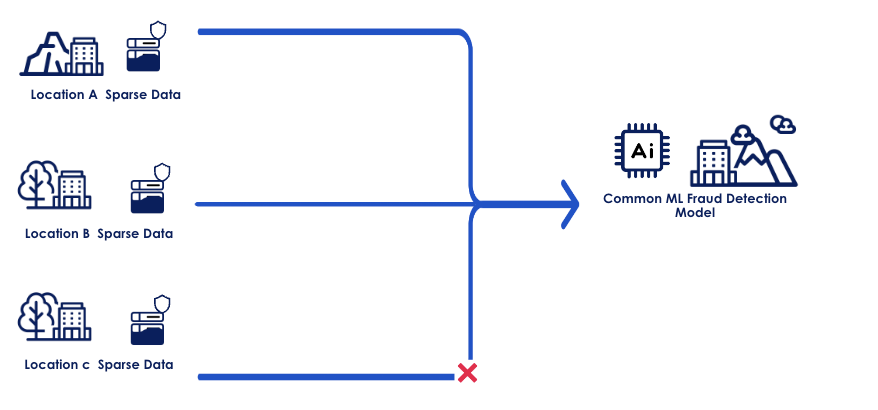



**Steps With Rockfish to improve the model performance**


*   Train the Rockfish Model with Location C Data which can be queried by the Central Location to generate data locally.
*   Blend the real data from Location A and Location B and synthetic data from Location C
*   Amplify the rare fraud events and train the fraud detection model with the blended data


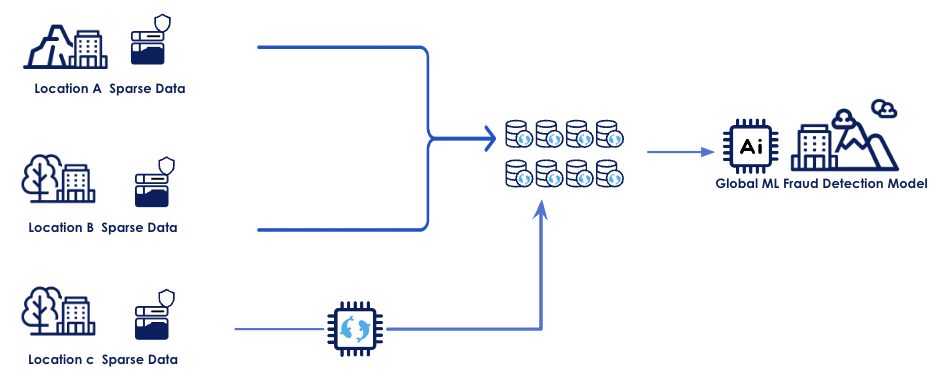


# 1. Query the Location C Rockfish Trained Model from the central location and generate synthetic copy of the data

### Query the location C model from the model store

In [ ]:
location1_model = await search_model({'location': 'location1'}, conn)

### Generate synthetic data by providing an amplification config

In [11]:
amplify_config = ra.PostAmplify({
    'query_ast': {
        'eq': ['fraud', 1]
    },
    'drop_match_percentage': 0,
    'drop_other_percentage': .998
})
#data = await generate_data(location1_model, amplify_config, conn)
data = pcv.read_csv('./demo2_synthetic_from_location1.csv')

# 2. Blend the synthetic data from location C with the already present real data from location A and location B

In [12]:
data_base = pd.concat([pd.read_csv('./location2.csv'), pd.read_csv('./location3.csv')])

In [13]:
data = pd.concat([data_base, data.to_pandas()])
X, y = create_X_y_for_xgb([data])

# 3. Train the fraud classification model with this blended data

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [15]:
clf_with_synthetic = get_xgb_clf(X_train, y_train, X_valid, y_valid)

# 4. Compare the performance of the fraud classification model trained with real data vs model trained with blended data

clarify what testing and loading in one step means

### Prepare the testing data that is present in the central location

In [16]:
test_data = pd.read_csv('./testing.csv')

In [17]:
X, y = create_X_y_for_xgb([test_data])

### Load the downstream model that was trained without synthetic data

In [18]:
clf_default = pickle.load(open('./base_model.mdl', 'rb'))

# 5. Comparison Results

In [19]:
synthetic_precision, synthetic_recall = [], []
for i in range(250):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    clf_with_synthetic = get_xgb_clf(X_train, y_train, X_valid, y_valid)

    y_pred_with_synthetic = clf_with_synthetic.predict(X)

    synthetic_recall.append(recall_score(y, y_pred_with_synthetic))
    synthetic_precision.append(precision_score(y, y_pred_with_synthetic))

In [20]:
synthetic_precision = np.array(synthetic_precision)
synthetic_recall = np.array(synthetic_recall)

y_pred_default = clf_default.predict(X)
default_metrics = metrics(y, y_pred_default)

In [21]:
pd.DataFrame({
    'Mean Precision': [default_metrics.precision.mean(), synthetic_precision.mean()],
    'Standard Deviation Precision': [0, synthetic_precision.std()],
    'Mean Recall': [default_metrics.recall.mean(), synthetic_recall.mean()],
    'Standard Deviation Recall': [0, synthetic_recall.std()]
},
index=['Default Model', 'Blended Synthetic Data Model'])

,Mean Precision,Standard Deviation Precision,Mean Recall,Standard Deviation Recall
Default Model,0.863636,0.000000,0.527778,0.000000
Model with Blended Synthetic Data,0.912875,0.029512,0.789778,0.045265


In [22]:
print(f'''
Metric Report:

Default Model:
    Precision: {default_metrics.precision.mean()}
    Recall: {default_metrics.recall.mean()}
    
Model with Blended Synthetic Data:
    Mean Precision: {synthetic_precision.mean()} with a standard deviation of: {synthetic_precision.std()}
    Mean Recall: {synthetic_recall.mean()} with a standard deviation of: {synthetic_recall.std()}
''')


Metric Report:

Default Model:
    Precision: 0.8636363636363636
    Recall: 0.5277777777777778
    
Model with Blended Synthetic Data:
    Mean Precision: 0.912875355563248 with a standard deviation of: 0.029511599559120666
    Mean Recall: 0.7897777777777778 with a standard deviation of: 0.04526479023002207



- The model trained with a blend of synthetic data to account for missing data from location1 has a 26% improvement in recall compared to the model trained without synthetic data. 
- This means that the model can now detect fraud as fraud 27% better than the previous model. 
- This is a significant improvement in the model's performance.